In [1]:
dataset <- "ARPAFVG"
state <- "Friuli-Venezia Giulia"
match_dist <- 15000


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 1000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!state %in% c("Veneto"), !(network %in% c("Sinottica", "Mareografica")))
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(c(dataset, "SCIA", "ISAC"), "qc1", conns$data) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [8]:
analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(0L))
analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", "FVG", "raw_analysis.xlsx"))


In [9]:
source("notebooks/integrazioni_regionali/FVG/procedures/match_taggers.R")
analysis |>
    tag_same_series() |>
    write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", "FVG", "tagged_analysis.xlsx"), starts_with("tag_"))


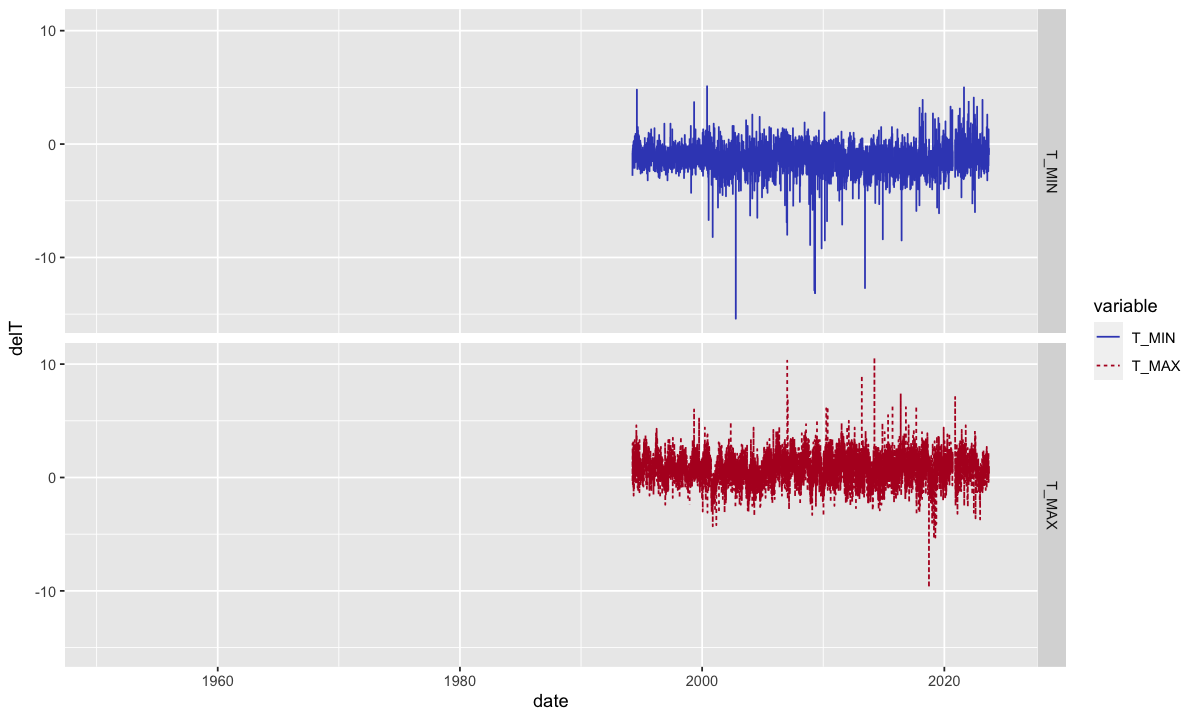

In [18]:
options(repr.plot.width = 10, repr.plot.height = 6)
plot_diffs(
    analysis |>
        filter(sensor_key_x == 52L, sensor_key_y == 4031L, dataset_x == "ARPAFVG", dataset_y == "ISAC") |>
        mutate(offset_days = 0L),
    data
) + facet_grid(variable ~ .)


In [40]:
path <- file.path(path.ds, "ARPA", "FVG", "test")
arpa <- vroom::vroom(list.files(file.path(path, "AFVG"), full.names = TRUE), delim = ";", n_max = 365L, id = "filename") |>
    as_tibble() |>
    mutate(year = basename(filename) |> fs::path_ext_remove() |> as.integer(), date = make_date(year, mese, `giorno*`)) |>
    select(date, T_MIN = `Temp. min gradi C`, T_MAX = `Temp. max gradi C`)
scia <- vroom::vroom(file.path(path, "ENEMONZO_SCIA.csv"), skip = 4L, col_names = c("date", "T_MAX")) |>
    as_tibble() |>
    mutate(date = as.Date(date))


Rows: 1825 Columns: 15
-- Column specification --------------------------------------------------------
Delimiter: ";"
chr  (1): Umidita' med %
dbl (13): mese, giorno*, Pioggia mm, Temp. min gradi C, Temp. med gradi C, T...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4748 Columns: 2
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl  (1): T_MAX
date (1): date

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [48]:
enem <- data |>
    filter(sensor_key == 20L, dataset == "ARPAFVG", variable == 1L) |>
    collect() |>
    rename(T_MAX = value)


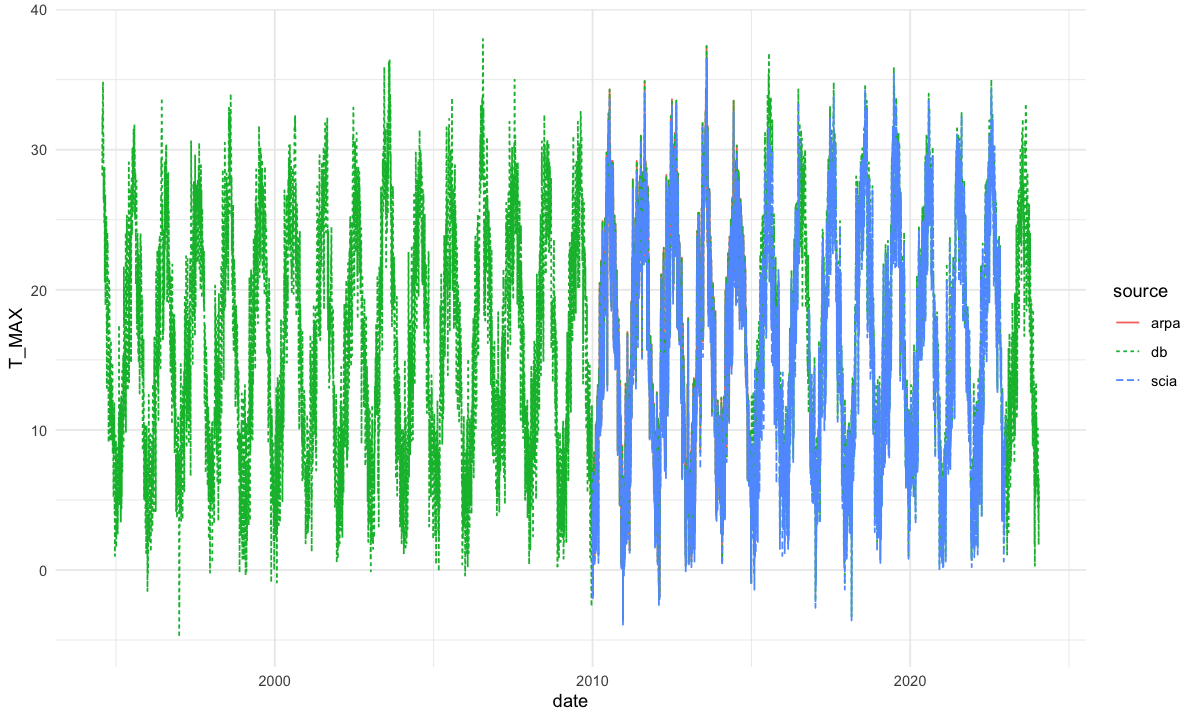

In [49]:
bind_rows(scia = scia, arpa = arpa, db = enem, .id = "source") |>
    ggplot(aes(date, T_MAX, color = source, linetype = source)) +
    geom_line() +
    theme_minimal()


Warning message:
"Removed 5996 rows containing missing values (`geom_line()`)."


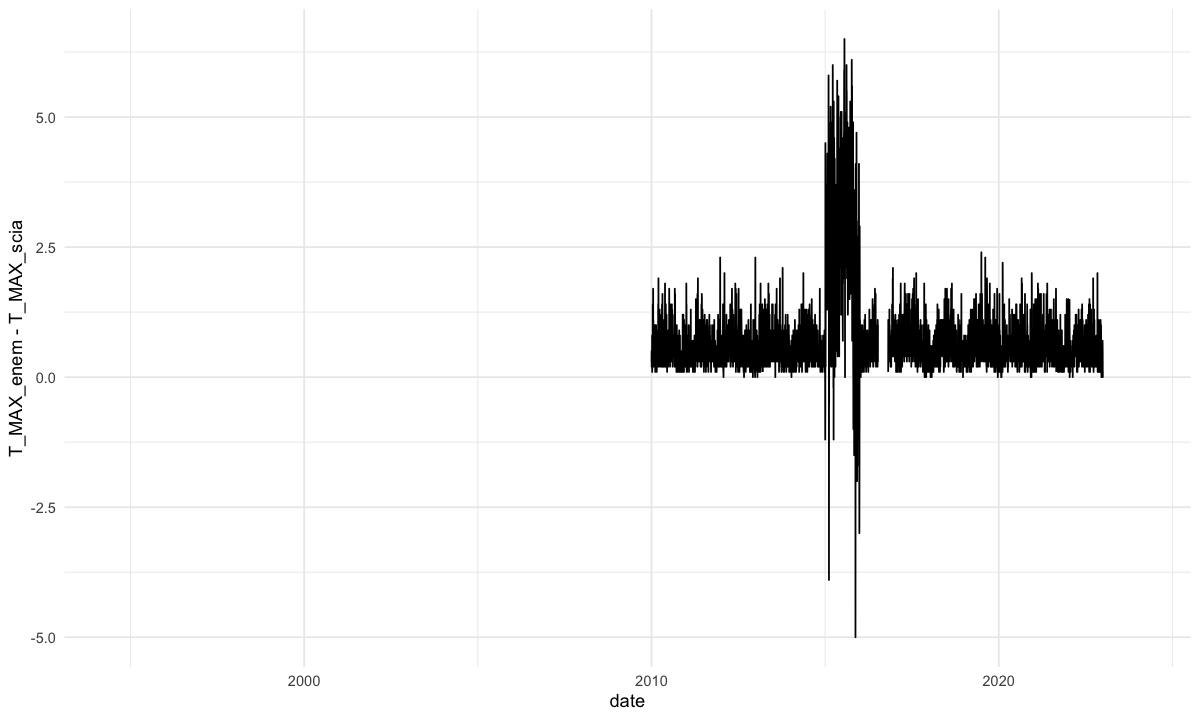

In [54]:
full_join(enem, scia, by = "date", suffix = c("_enem", "_scia")) |>
    ggplot(aes(date, T_MAX_enem - T_MAX_scia)) +
    geom_line() +
    theme_minimal()


In [ ]:
source(file.path("notebooks", "integrazioni_regionali", "FVG", "procedures", "match_taggers.R"))
source("src/merging/tagging.R")
tagged_analysis <- tag_same_series(analysis) |>
    tag_mergeable() |>
    default_logic(require_all = TRUE)
tagged_analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", "FVG", "tagged_analysis.xlsx"), starts_with("tag_"))


In [49]:
analysis |>
    filter(valid_days_inters > 160L, abs(balance) > 0.8) |>
    group_by(key_x, key_y) |>
    filter(prod(balance) < 0, strSym > 0.8) |>
    ungroup() |>
    write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", "FVG", "unbalanced.xlsx"))


In [19]:
library(lubridate)


In [79]:
library(tsibble)
gen_ts <- function() {
    start <- ymd_hms("2000-01-01 00:00:00")
    end <- ymd_hms("2001-01-01 00:00:00")
    t <- seq(start, end, by = "1 min")
    tt <- 2 * pi * seconds(t - start) / 86400 |> as.numeric()
    temp <- 20 + 5 * sin(tt) + runif(length(t), -5, 5)

    tibble(t = t, temp = temp) |>
        as_tsibble(index = t)
}


In [82]:
s1 <- gen_ts()


In [83]:
s1_hourly <- s1 |>
    index_by(hour = ~ lubridate::floor_date(., "1 hour")) |>
    summarise(temp = mean(temp))
# s2_hourly <- s2 |>
#     group_by_key() |>
#     index_by(hour = ~ lubridate::floor_date(., "1 hour")) |>
#     summarise(value = mean(value))


In [87]:
s1_extremes <- s1 |>
    index_by(date = ~ as.Date(.)) |>
    summarise(tmax = max(temp), tmin = min(temp)) |>
    pivot_longer(c(tmin, tmax), names_to = "variable", values_to = "value")

s1_daily_0 <- s1_hourly |>
    index_by(date = ~ as.Date(.)) |>
    summarise(tmax = max(temp), tmin = min(temp)) |>
    pivot_longer(c(tmin, tmax), names_to = "variable", values_to = "value")

s1_daily_9 <- s1_hourly |>
    index_by(date = ~ as.Date(. - as.difftime(9, units = "hours"))) |>
    summarise(tmax = max(temp), tmin = min(temp)) |>
    pivot_longer(c(tmin, tmax), names_to = "variable", values_to = "value")


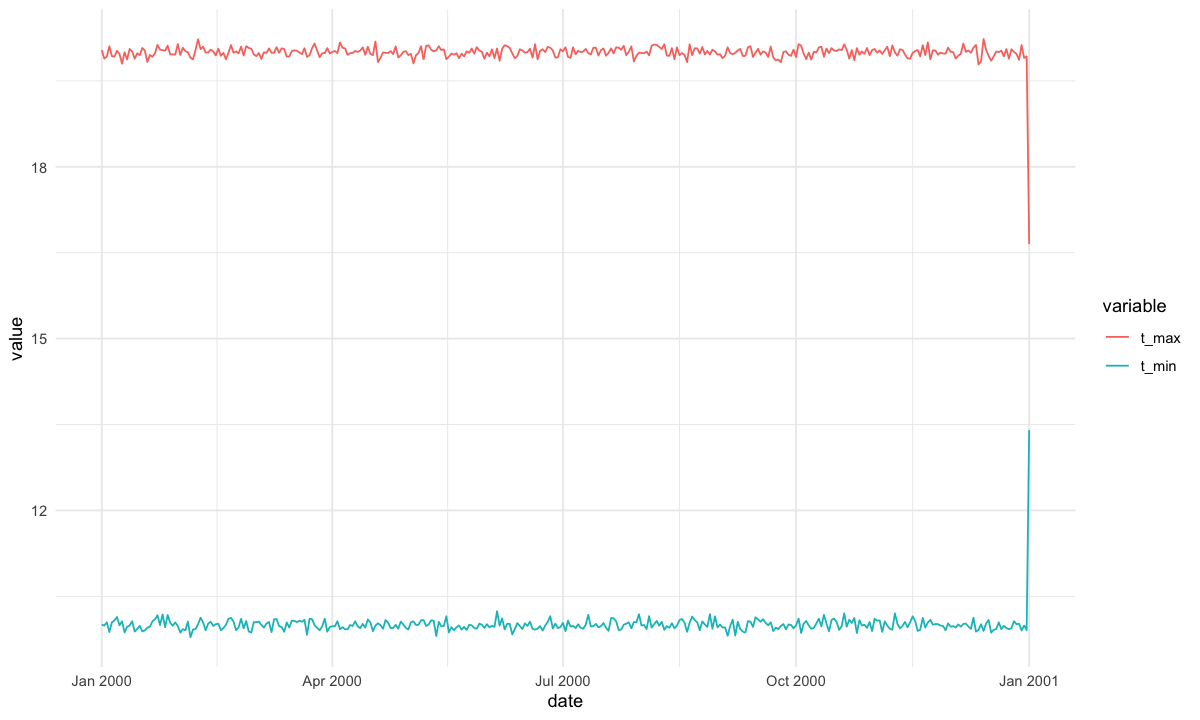

In [70]:
s1_daily_0 |>
    ggplot() +
    geom_line(aes(date, value, color = variable)) +
    theme_minimal()
